In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D      
from functools import partial
from rikabplotlib.plot_utils import newplot

Text(0.5, 0, '$p(t_a, t_b)$')

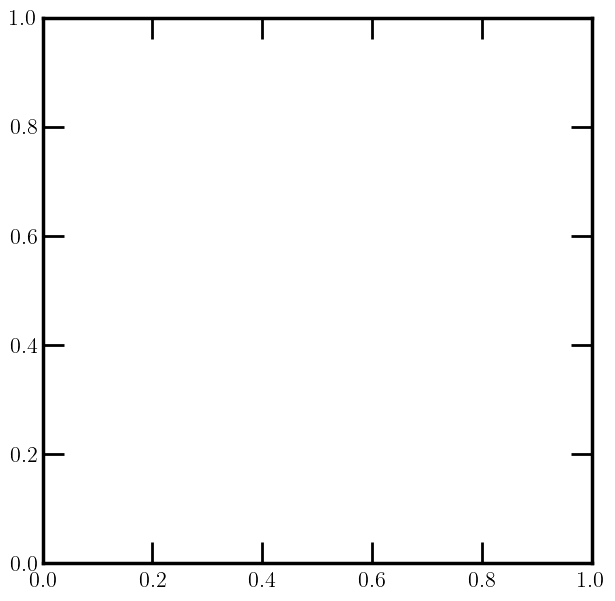

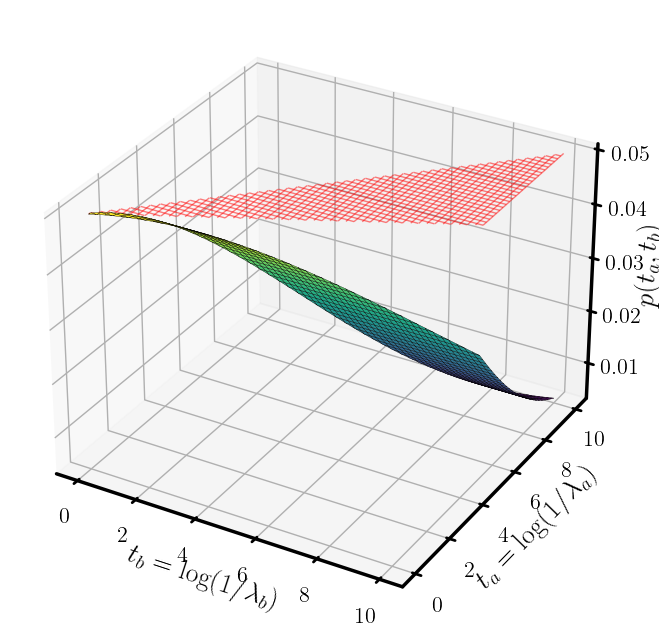

In [ ]:
def Theta(x):

    return jnp.where(x > 0, 1.0, 0.0)



alpha = 0.118
C_F = 4/3
a = 2
b = 1


def pdf_x(lam_a, lam_b):

    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)

    pref = alpha * C_F / jnp.pi 
    return pref / (a - b) / lam_a / lam_b * theta_1 * theta_2


def pdf_t(t_a, t_b):

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    return pref / (a - b) * theta_1 * theta_2



def rdf_t(t_a, t_b):

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    exp = jnp.exp(-C_F * alpha / 2 / jnp.pi / b * t_b**2)
    return pref / (a - b) * theta_1 * theta_2 * exp


# Draw 3d plot of the PDF
fig, ax = newplot("full")
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
t_a = jnp.linspace(0.00, 10, 1000)
t_b = jnp.linspace(0.00, 10, 1000)
X, Y = jnp.meshgrid(t_a, t_b)
Z = pdf_t(X, Y)   
Z = jnp.where(Z < 1e-10, jnp.nan, Z)  # Avoid log(0) issues
Z_r = rdf_t(X, Y)
Z_r = jnp.where(Z_r < 1e-10, jnp.nan, Z_r)  # Avoid log(0) issues

ax.plot_wireframe(X, Y, Z, color = "white", edgecolor='red', rcount = 50, ccount = 50, alpha=0.5, lw = 1, label = "Fixed Order")
ax.plot_surface(X, Y, Z_r, cmap = "viridis", edgecolor='black',  lw = 0.25, label = "RDF")
ax.set_xlabel(r'$t_a = \log(1/\lambda_a)$')
ax.set_ylabel(r'$t_b = \log(1/\lambda_b)$')
ax.set_zlabel(r'$p(t_a, t_b)$')
# ax.legend()

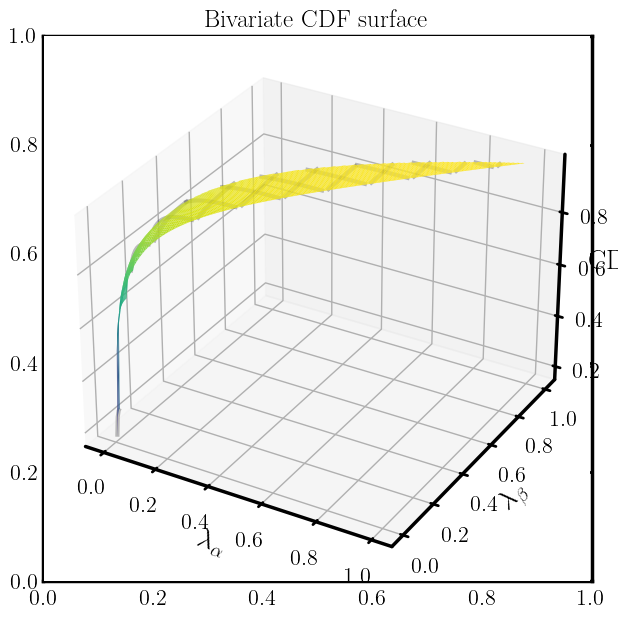

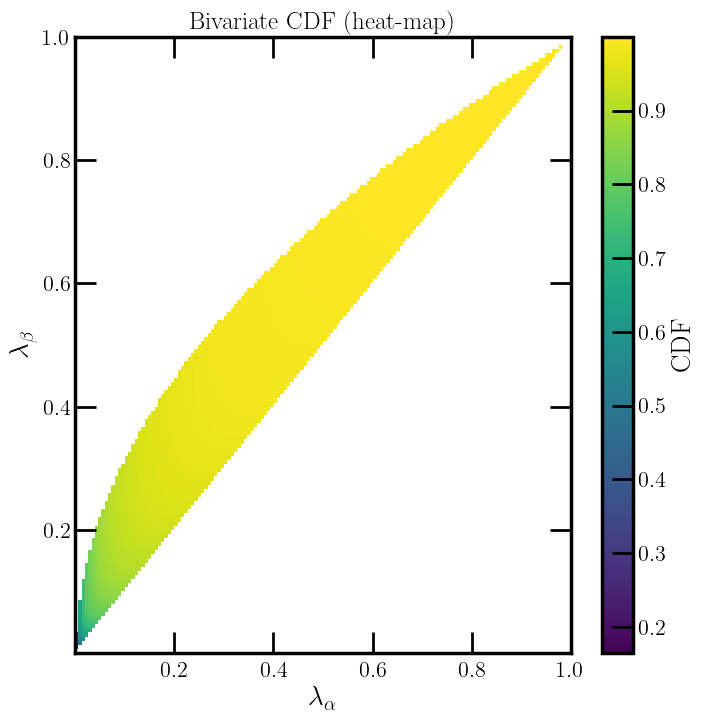

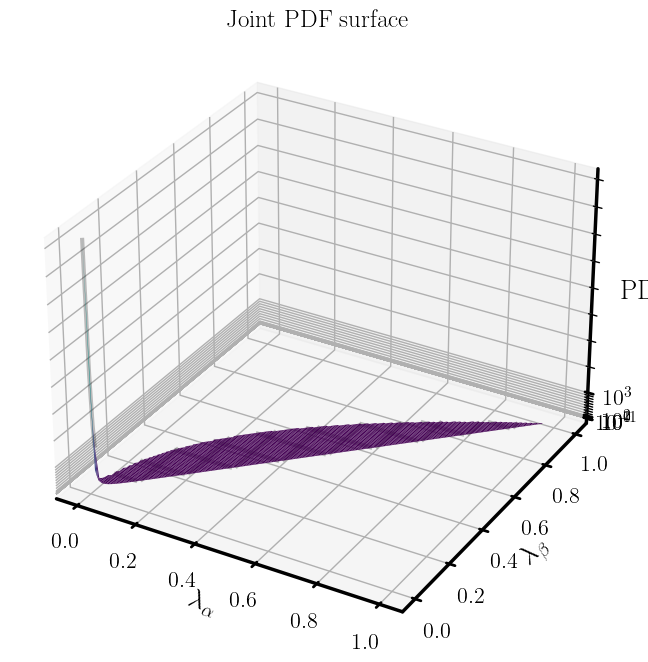

AttributeError: module 'matplotlib.pyplot' has no attribute 'LogNorm'

<Figure size 800x800 with 0 Axes>

In [4]:

def Theta(x):
    return jnp.where(x > 0, 1.0, 0.0)


@jit
def cdf(lam_a, lam_b, alpha_s, alpha, beta):
    

    theta_1 = Theta(lam_a**beta - lam_b**alpha)
    theta_2 = Theta(lam_b - lam_a)

    pref = alpha_s / jnp.pi
    piece = (
        -7.0 / (4.0 * beta)
        - 3.0 * jnp.log(lam_b) / (2.0 * beta)
        - jnp.log(lam_b) ** 2 / beta
        + 2.0 * lam_a / alpha
        - lam_a ** 2 / (4.0 * alpha)
        + 2.0 * (alpha - beta)
          / (alpha * beta)
          * lam_a ** (-beta / (alpha - beta))
          * lam_b ** (alpha / (alpha - beta))
        - (alpha - beta)
          / (4.0 * alpha * beta)
          * lam_a ** (-2.0 * beta / (alpha - beta))
          * lam_b ** (2.0 * alpha / (alpha - beta))
        - jnp.log(lam_a / lam_b) ** 2 / (alpha - beta)
    )

    return 1.0 + pref * theta_1 * theta_2 * piece



def make_pdf(alpha_s, alpha, beta):

    f_cdf = lambda la, lb: cdf(la, lb, alpha_s, alpha, beta)
    dF_dla  = jit(grad(f_cdf, argnums=0))  
    pdf_fn  = jit(grad(dF_dla, argnums=1)) 
    return pdf_fn



alpha_s=0.118
alpha=2.0
beta=1.0
lam_min=1e-3
lam_max=1.0
n_pts=150

pdf = make_pdf(alpha_s, alpha, beta)

lam_a = jnp.linspace(lam_min, lam_max, n_pts)
lam_b = jnp.linspace(lam_min, lam_max, n_pts)
LA, LB = jnp.meshgrid(lam_a, lam_b, indexing="ij")

# Vectorised evaluation on the grid
F_vmap = jit(vmap(vmap(lambda a, b: cdf(a, b, alpha_s, alpha, beta),
                    in_axes=(None, 0)),                  
                in_axes=(0, None)))                      

f_vmap = jit(vmap(vmap(pdf, in_axes=(None, 0)),          
                in_axes=(0, None)))                      

CDF = F_vmap(lam_a, lam_b)
PDF = f_vmap(lam_a, lam_b)

# Set 1 in the CDF to nan
CDF = jnp.where(CDF == 1.0, jnp.nan, CDF)
PDF = jnp.where(PDF < 1e-10, jnp.nan, PDF)

# 3-D surface (CDF)
fig, ax = newplot("full")
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(LA, LB, CDF, rcount=200, ccount=200, cmap='viridis')
ax.plot_wireframe(LA, LB, CDF, color='k', alpha=0.25, rcount=10, ccount=10)
ax.set(xlabel=r'$\lambda_\alpha$', ylabel=r'$\lambda_\beta$', zlabel='CDF',
        title='Bivariate CDF surface')
plt.show()

# 2-D colour map (CDF)
plt.figure()
plt.imshow(CDF.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto')
plt.colorbar(label='CDF')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta$')
plt.title('Bivariate CDF (heat-map)')
plt.show()

# 3-D surface (PDF)
fig2 = plt.figure()
ax2  = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(LA, LB, PDF, rcount=200, ccount=200, cmap='viridis')
ax2.plot_wireframe(LA, LB, PDF, color='k', alpha=0.25, rcount=10, ccount=10)

# Set log scale for z-axis
ax2.set(xlabel=r'$\lambda_\alpha$', ylabel=r'$\lambda_\beta$', zlabel='PDF',
        title='Joint PDF surface')

# Make z-axis log 
ax2.set_zscale('log')

plt.show()

# 2-D colour map (PDF)
plt.figure()
plt.imshow(PDF.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto', vnorm = plt.LogNorm())
plt.colorbar(label='PDF')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta$')
plt.title('Joint PDF (heat-map)')
plt.show()


f_A = jnp.trapz(np.nan_to_num(PDF), lam_b, axis=1)
f_B = jnp.trapz(np.nan_to_num(PDF), lam_a, axis=0)

print(f_A)

# 1-D marginal PDF (A)
plt.figure()
plt.plot(lam_a, f_A, label=r'$f_A(\lambda_\alpha)$')
plt.xlabel(r'$\lambda_\alpha$')
plt.ylabel('PDF')
plt.title('Marginal PDF (A)')
plt.legend()
plt.show()  

# 1-D marginal PDF (B)
plt.figure()
plt.plot(lam_b, f_B, label=r'$f_B(\lambda_\beta)$')
plt.xlabel(r'$\lambda_\beta$')
plt.ylabel('PDF')  
plt.title('Marginal PDF (B)')
plt.legend()
plt.show()


# Conditional PDF (A|B)
f_A_given_B = PDF / f_B[:, None]
print(f_A_given_B)

# 2-D colour map (Conditional PDF A|B)
plt.figure()
plt.imshow(f_A_given_B.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto')
plt.colorbar(label=r'$f_A(\lambda_\alpha | \lambda_\beta)$')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta$')
plt.title('Conditional PDF (A|B) (heat-map)')
plt.show()

# Conditional PDF (B|A)
f_B_given_A = PDF / f_A[None, :]  
# 2-D colour map (Conditional PDF B|A)
plt.figure()
plt.imshow(f_B_given_A.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto')
plt.colorbar(label=r'$f_B(\lambda_\beta | \lambda_\alpha)$')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta  $')
plt.title('Conditional PDF (B|A) (heat-map)')
plt.show()  
